## Data Preparation

In [133]:
#Load stock data

import pandas_datareader as web
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt

import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cut_tree
from scipy.spatial.distance import pdist

from sklearn.linear_model import LinearRegression

Tickers_bank=['JPM','BAC','C','WFC','GS','MS','USB','TD','PNC']
Tickers_consumer=['PEP','KO','MCD','YUM','SBUX','CMG']
Tickers=Tickers_bank+Tickers_consumer
start_date='2012-04-01'
end_date='2014-04-01' #must before back-tracking time
stock_data= web.get_data_yahoo(Tickers, start=start_date, end=end_date)

In [134]:
import warnings
warnings.filterwarnings(action='ignore')

## Indicators calculation

In [135]:
data = {}
data['ret'] = stock_data['Adj Close'].pct_change() * 100.0
data['ret_5'] = stock_data['Adj Close'].pct_change().shift(4) * 100.0
data['ret_ratio'] = (data['ret'] / data['ret_5'] - 1) * 100.0
data['gap'] = ((stock_data['Open'] - stock_data['Adj Close'].shift()) / stock_data['Open'] * 100.0)
data['hl'] = ((stock_data['High'] - stock_data['Low']) / stock_data['Open'] * 100.0)
data['MA_short'] = stock_data['Adj Close'].apply(lambda x: talib.EMA(x, 10))
data['MA_long'] = stock_data['Adj Close'].apply(lambda x: talib.EMA(x, 60))
data['MA_ratio'] = (data['MA_short'] / data['MA_long'] - 1) * 100.0
data['vol_short'] = stock_data['Adj Close'].rolling(10).std()
data['vol_long'] = stock_data['Adj Close'].rolling(60).std()
data['vol_ratio'] = (data['vol_short'] / data['vol_long'] - 1) * 100.0
data['MOM'] = stock_data['Adj Close'].apply(lambda x: talib.MOM(x, timeperiod=10) / 100)
data['skewness'] = data['ret'].rolling(10).skew()
data['kurtosis'] = data['ret'].rolling(10).kurt() - 3
data['RSI'] = stock_data['Adj Close'].apply(lambda x: talib.RSI(x) / 100)
data=pd.concat(data.values(),axis=1,keys=data.keys())
stock_data=pd.concat([stock_data,data],axis=1)
stock_data.dropna(inplace=True)

    #reconstruct data, indexed by labels
stock_data.columns = stock_data.columns.swaplevel(1, 0)
stock_data.sort_index(axis=1,inplace=True)

## PCA

In [137]:
n_comp=3
normalize=True
variance=True

In [140]:
stock_data=stock_data.replace([np.inf,-np.inf],np.nan)
stock_data.fillna(method='ffill',inplace=True)
if normalize:
    scaler=MinMaxScaler()
    data_scaled=scaler.fit_transform(np.array(stock_data))
    data_scaled=pd.DataFrame(data_scaled,columns=stock_data.columns)
    data_scaled=data_scaled.stack().unstack(level=0).T
else:
    data_scaled=data_scaled.stack().unstack(level=0).T
pca=PCA(n_components=n_comp).fit(np.array(data_scaled))
print(np.sum(pca.explained_variance_ratio_))
stock_PCA=pd.DataFrame(pca.transform(np.array(data_scaled)))
stock_PCA.index=stock_data.index
stock_PCA=stock_PCA.T.stack(level=0).T

0.7299823036758258


In [143]:
stock_PCA

0                                                    \
Symbols          BAC         C       CMG        GS       JPM        KO   
Date                                                                     
2012-06-26 -1.225157 -1.195812 -0.112317 -1.360667 -1.221576 -0.948761   
2012-06-27 -1.208652 -1.190286 -0.220710 -1.338161 -1.164657 -0.807310   
2012-06-28 -1.169027 -1.215219 -0.316681 -1.305695 -1.168307 -0.732424   
2012-06-29 -1.199224 -1.224067 -0.320928 -1.303575 -1.244043 -0.529745   
2012-07-02 -1.138553 -1.163706 -0.308310 -1.234288 -1.191650 -0.365010   
2012-07-03 -1.116810 -1.144721 -0.311016 -1.188924 -1.163364 -0.264147   
2012-07-05 -1.157773 -1.192349 -0.311892 -1.215930 -1.273138 -0.305831   
2012-07-06 -1.164468 -1.218680 -0.310652 -1.224249 -1.289024 -0.354356   
2012-07-09 -1.218262 -1.258528 -0.303363 -1.257449 -1.317191 -0.374037   
2012-07-10 -1.272222 -1.293867 -0.330085 -1.287031 -1.314870 -0.371421   
2012-07-11 -1.243124 -1.294592 -0.350040 -1.270494 -1.288220 -0.449820   
2012-07-12 -1.228385 -1.318681 -0.339870 -1.278458 -1.309857 -0.557818   
2012-07-13 -1.240776 -1.301313 -0.301373 -1.264705 -1.289757 -0.544392   
2012-07-16 -1.222063 -1.280303 -0.269673 -1.226150 -1.238085 -0.587217   
2012-07-17 -1.208978 -1.230733 -0.244945 -1.252564 -1.289528 -0.499371   
2012-07-18 -1.254684 -1.206020 -0.240200 -1.225404 -1.254068 -0.499578   
2012-07-19 -1.337608 -1.245697 -0.217071 -1.275715 -1.293792 -0.510318   
2012-07-20 -1.328422 -1.276190 -0.610598 -1.285434 -1.315974 -0.530884   
2012-07-23 -1.330134 -1.308852 -0.722654 -1.306659 -1.336597 -0.572292   
2012-07-24 -1.379614 -1.364678 -0.792840 -1.310170 -1.305044 -0.603672   
2012-07-25 -1.377037 -1.343350 -0.804084 -1.281095 -1.276285 -0.555786   
2012-07-26 -1.377446 -1.324789 -0.850147 -1.241004 -1.237254 -0.365391   
2012-07-27 -1.342132 -1.269129 -0.857558 -1.172338 -1.192099 -0.162967   
2012-07-30 -1.311028 -1.218044 -0.869376 -1.113120 -1.138886  0.005238   
2012-07-31 -1.329749 -1.221597 -0.886400 -1.109859 -1.154560  0.074183   
2012-08-01 -1.345279 -1.258094 -0.953188 -1.126986 -1.166503  0.117889   
2012-08-02 -1.335259 -1.263952 -0.993948 -1.159693 -1.220520  0.009945   
2012-08-03 -1.352967 -1.264606 -0.932495 -1.153123 -1.208532  0.078622   
2012-08-06 -1.275003 -1.160737 -0.924674 -1.096667 -1.157747  0.128212   
2012-08-07 -1.252539 -1.092201 -0.899430 -1.069054 -1.133377  0.029240   
...              ...       ...       ...       ...       ...       ...   
2014-02-20  0.957514  0.743073  0.875769  0.872995  1.042248 -0.478908   
2014-02-21  0.963484  0.745899  0.871748  0.889941  1.044694 -0.468567   
2014-02-24  0.984711  0.777658  0.887144  0.918119  1.064663 -0.442384   
2014-02-25  0.980931  0.769402  0.903376  0.881415  1.018931 -0.372180   
2014-02-26  0.949345  0.739351  0.900646  0.841407  0.967988 -0.329432   
2014-02-27  0.979386  0.760522  0.924787  0.888134  0.968994 -0.292655   
2014-02-28  0.986125  0.764379  0.963123  0.935856  0.977247 -0.240838   
2014-03-03  0.973046  0.722427  0.923846  0.929273  0.943942 -0.275136   
2014-03-04  0.994202  0.737616  1.012519  0.968443  0.972515 -0.199542   
2014-03-05  1.105776  0.807877  1.077777  1.059838  1.054969 -0.174939   
2014-03-06  1.182436  0.840676  1.129279  1.127564  1.130327 -0.153190   
2014-03-07  1.192256  0.839066  1.162120  1.161034  1.189385 -0.129729   
2014-03-10  1.238728  0.848409  1.147531  1.180330  1.205734 -0.104728   
2014-03-11  1.219672  0.781935  1.133192  1.105410  1.143240 -0.063639   
2014-03-12  1.212308  0.743330  1.133368  1.077575  1.113243 -0.107199   
2014-03-13  1.181624  0.688142  1.115331  1.015171  1.072579 -0.201890   
2014-03-14  1.124841  0.663322  1.082127  0.977590  1.030182 -0.209043   
2014-03-17  1.127649  0.688408  1.078534  0.988610  1.046303 -0.175574   
2014-03-18  1.155312  0.723953  1.134394  1.017410  1.087786 -0.144018   
2014-03-19  1.187815  0.765251  1.183463  1.013723  1.107866 -0.169783   
2014-03-20  1.269119  0

## Cluster

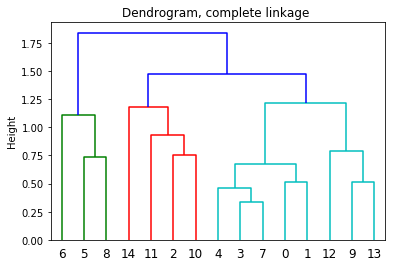

In [144]:
#use correlation as the similarity measurement
stock_PCA.sort_index(axis=1,inplace=True)

Distance_mat1=pdist(np.array(stock_PCA[0].T),'correlation')
Distance_mat2=pdist(np.array(stock_PCA[1].T),'correlation')
Distance_mat3=pdist(np.array(stock_PCA[2].T),'correlation')
D=(Distance_mat1+Distance_mat2+Distance_mat3)/3 #take an average of them as the total measure
D=(D+D.T)/2
D=squareform(D)
D
tree=hierarchy.linkage(D,'complete')
plt.figure()
dn=hierarchy.dendrogram(tree)
plt.title('Dendrogram, complete linkage ')
plt.ylabel('Height')
plt.show()

## Select Pairs

In [157]:
stock_PCA.columns.get_level_values(1)

Index(['BAC', 'C', 'CMG', 'GS', 'JPM', 'KO', 'MCD', 'MS', 'PEP', 'PNC', 'SBUX',
       'TD', 'USB', 'WFC', 'YUM', 'BAC', 'C', 'CMG', 'GS', 'JPM', 'KO', 'MCD',
       'MS', 'PEP', 'PNC', 'SBUX', 'TD', 'USB', 'WFC', 'YUM', 'BAC', 'C',
       'CMG', 'GS', 'JPM', 'KO', 'MCD', 'MS', 'PEP', 'PNC', 'SBUX', 'TD',
       'USB', 'WFC', 'YUM'],
      dtype='object', name='Symbols')

We can see that, bank industries tend to have closer movements compared with consumer industries. We would like to select one pair from each of these two industries. Based on dendrogram, for banking industry, we choose ['GS,'MS'] (indexes 3 and 7) and for consumer industry, we choose ['KO','PEP'] (index 5 and 8)

In [162]:
stock_data.columns = stock_data.columns.swaplevel(1, 0)

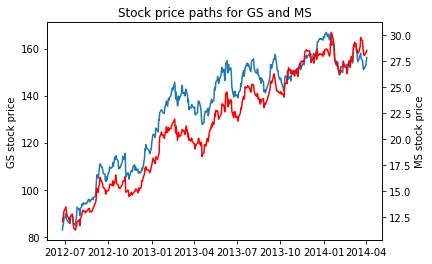

In [163]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(stock_data.index,stock_data['Adj Close']['GS'])
ax1.set_ylabel('GS stock price')
ax1.set_title("Stock price paths for GS and MS")

ax2 = ax1.twinx()
ax2.plot(stock_data.index,stock_data['Adj Close']['MS'], 'r')
ax2.set_ylabel('MS stock price')
ax2.set_xlabel('Date')

plt.show()


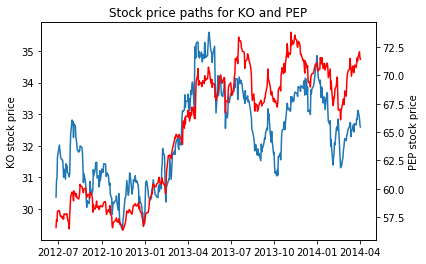

In [164]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.plot(stock_data.index,stock_data['Adj Close']['KO'])
ax1.set_ylabel('KO stock price')
ax1.set_title("Stock price paths for KO and PEP")

ax2 = ax1.twinx()  
ax2.plot(stock_data.index,stock_data['Adj Close']['PEP'], 'r')
ax2.set_ylabel('PEP stock price')
ax2.set_xlabel('Date')

plt.show()

## Get spread between pairs

In [219]:
def getSpread(pairs,window=60,end_date='2014-06-01'):
#     '''pairs should be in format [[p1,p2],[p1,p2]]
#     return spread, index:date,value:spread'''

    tmp=datetime.datetime.strptime(end_date, '%Y-%m-%d')
    delta = datetime.timedelta(days=window)
    start_date=(tmp-delta).strftime('%Y-%m-%d')
    spread={}
    #download data, compute return
    for i,pair in enumerate(pairs):
        stock_data=web.get_data_yahoo(pair, start=start_date, end=end_date)['Adj Close']
        ret = stock_data.pct_change() * 100.0
        ret=ret[1:]
        days=ret.shape[0]
        X=ret[pair[0]].values.reshape((days,1))
        y=ret[pair[1]].values.reshape((days,1))
        lr=LinearRegression().fit(X,y)
        spread['pair'+str(i+1)]=(y-lr.predict(X)).reshape(days)
    spread=pd.DataFrame(spread,index=stock_data.index[1:])
    return spread

In [220]:
window=60
end_date='2014-06-01'

In [221]:
print(getSpread(pairs))

               pair1     pair2
Date                          
2014-04-03 -0.766573  0.451262
2014-04-04 -0.057639 -0.643242
2014-04-07  0.291587  1.042222
2014-04-08  1.347119 -0.933198
2014-04-09  1.122468  0.344318
2014-04-10 -1.767028 -0.305063
2014-04-11 -0.436246 -0.332861
2014-04-14  0.525442  0.285671
2014-04-15  1.474505 -1.300250
2014-04-16 -0.575615  0.420649
2014-04-17  2.672915  0.696646
2014-04-21  0.379138  0.310193
2014-04-22 -1.238549 -0.928227
2014-04-23 -0.588816  0.217718
2014-04-24 -0.680997  0.085666
2014-04-25  0.549541 -0.741326
2014-04-28 -0.501376  1.742429
2014-04-29  0.482284 -0.784503
2014-04-30  0.155331 -0.173589
2014-05-01  0.473776 -0.438192
2014-05-02 -0.752174 -0.326179
2014-05-05 -0.340581  0.591569
2014-05-06 -0.830110 -0.402183
2014-05-07  0.029813  1.123274
2014-05-08 -1.454551 -0.036724
2014-05-09  0.024047  0.354240
2014-05-12  0.452439 -0.296204
2014-05-13 -0.589324 -0.057007
2014-05-14  0.226511 -0.278974
2014-05-15  0.280945 -0.929286
2014-05-